# Customer Segmentation with K-Means (RFM)

Following the [EDA previously performed](https://github.com/rodolfoplng/Portfolio/blob/main/Grocery%20Store%20EDA.ipynb), 
this notebook builds RFM (Recency, Frequency, Monetary) features from raw sales data,
uses the Elbow method to explore the optimal number of clusters, and fits a
K-Means model with **4 clusters** targeting the following business segments:

1) **Champions** – recent, frequent, and high-spending customers  
2) **Loyal** – frequent buyers with moderate spending  
3) **At Risk** – customers with high recency (long time since last purchase)  
4) **Low Value** – infrequent and low-spending customers


## Imports & display options

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

pd.set_option("display.float_format", "{:,.2f}".format)

%matplotlib inline
plt.style.use("seaborn-v0_8")
sns.set_palette("viridis")

## Build the RFM table from the grocery store database

In [15]:
# Database credentials
db_user = "pguser"
db_pass = "pgpass"
db_host = "localhost"   # use "db" if running inside Docker
db_port = "5432"
db_name = "grocery"

# Create engine with default search_path
engine = create_engine(
    f"postgresql+psycopg2://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}",
    connect_args={"options": "-c search_path=raw,public"}
)

sql = """SELECT s.salesid, s.customerid, c.cityid, ci.cityname, p.productid, p.productname, 
s.quantity, s.discount, (p.price * s.quantity) as revenue, s.salesdate
FROM sales s
INNER JOIN customers c ON s.customerid = c.customerid
INNER JOIN cities ci ON c.cityid = ci.cityid
INNER JOIN products p ON s.productid = p.productid
WHERE s.salesdate >= '2018-01-01'
  AND s.salesdate <= '2018-04-30'
  AND s.quantity > 0"""

df = pd.read_sql(sql, engine)
df.head()

,salesid,customerid,cityid,cityname,productid,productname,quantity,discount,revenue,salesdate
0,1,27039,54,Albuquerque,381,Vaccum Bag 10x13,7,0.00,309.61,2018-02-05 07:38:25.430
1,2,25011,71,Phoenix,61,Sardines,7,0.00,437.85,2018-02-02 16:03:31.150
2,4,73966,45,Dallas,176,Smirnoff Green Apple Twist,19,0.20,"1,545.08",2018-04-07 14:43:55.420
3,5,32653,82,Charlotte,310,Coffee - Dark Roast,9,0.00,719.82,2018-02-12 15:37:03.940
4,6,28663,31,Wichita,413,Ice Cream Bar - Oreo Cone,8,0.00,763.28,2018-02-07 10:33:24.990


In [18]:
# Reference date for Recency (use max date + 1 day to get non-zero recency)
reference_date = df["salesdate"].max() + pd.Timedelta(days=1)

# Aggregate to RFM per customer
rfm = (
    df.groupby("customerid")
      .agg(
          monetary=("revenue", "sum"),
          frequency=("salesid", "count"),
          last_purchase=("salesdate", "max")
      )
      .reset_index()
)

# Recency in days (lower is better)
rfm["recency"] = (reference_date - rfm["last_purchase"]).dt.days.astype(int)

# Keep only R, F, M
rfm = rfm[["customerid", "recency", "frequency", "monetary"]].copy()

rfm.describe()

,customerid,recency,frequency,monetary
count,"98,759.00","98,759.00","98,759.00","98,759.00"
mean,"49,380.00",2.44,62.49,"41,295.11"
std,"28,509.41",1.87,7.87,"23,899.72"
min,1.00,1.00,28.00,"1,704.20"
25%,"24,690.50",1.00,57.00,"20,988.36"
50%,"49,380.00",2.00,62.00,"40,402.56"
75%,"74,069.50",3.00,68.00,"59,995.11"
max,"98,759.00",24.00,96.00,"117,620.75"


## Inspect distributions (quick EDA)

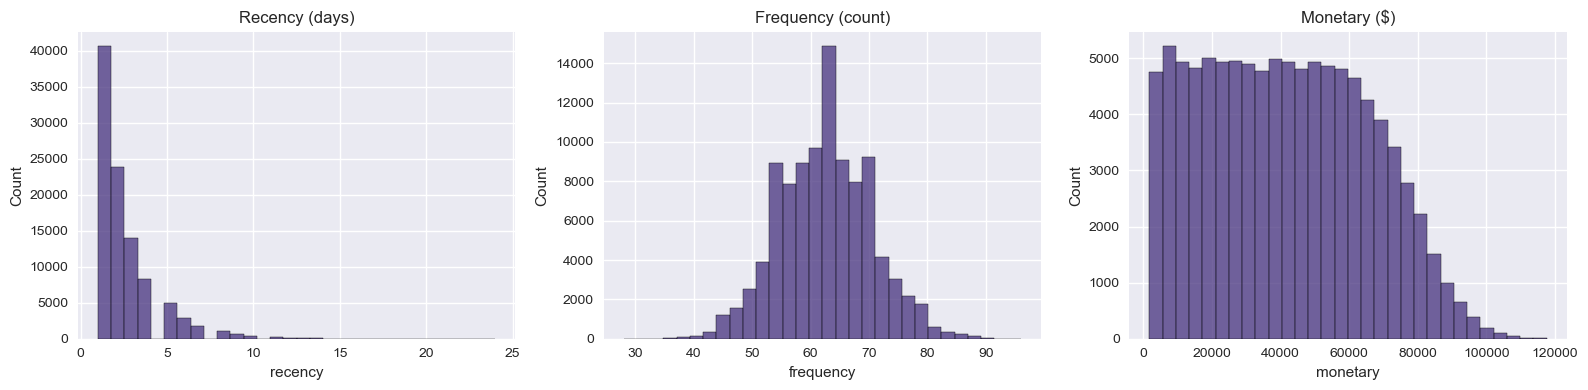

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
sns.histplot(rfm["recency"], bins=30, ax=axes[0]);   axes[0].set_title("Recency (days)")
sns.histplot(rfm["frequency"], bins=30, ax=axes[1]); axes[1].set_title("Frequency (count)")
sns.histplot(rfm["monetary"], bins=30, ax=axes[2]);  axes[2].set_title("Monetary ($)")
plt.tight_layout(); plt.show()

## Scale features (required for K-Means)

In [25]:
features = ["recency", "frequency", "monetary"]

scaler = StandardScaler()
X = scaler.fit_transform(rfm[features])

X[:3]  # preview

array([[-0.23483762, -0.18959622, -1.59319494],
       [ 2.43272562, -0.44373877, -1.59278196],
       [-0.23483762, -0.18959622, -1.60305493]])

## Elbow method (K vs inertia)

Text(0.5, 1.0, 'Elbow Method')

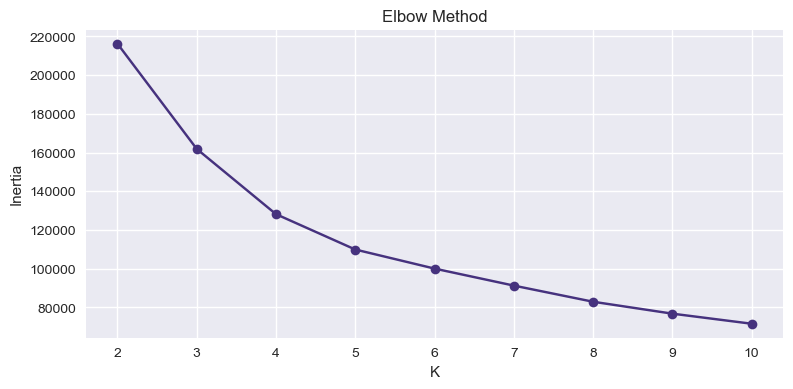

In [47]:
inertia, sil = [], []
K = range(2, 11)  # start at 2 clusters

for k in K:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(X)
    inertia.append(km.inertia_)

fig, ax1 = plt.subplots(figsize=(9,4))
ax1.plot(K, inertia, marker="o")
ax1.set_xlabel("K")
ax1.set_ylabel("Inertia")
ax1.set_title("Elbow Method")

## Fit K-Means with 4 clusters

In [43]:
k = 4
kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
rfm["cluster"] = kmeans.fit_predict(X)

# Centroids in scaled space -> transform back to original scale (optional)
centroids_scaled = kmeans.cluster_centers_
centroids = pd.DataFrame(scaler.inverse_transform(centroids_scaled), columns=features)
centroids["cluster"] = range(k)
centroids

,recency,frequency,monetary,cluster
0,1.94,54.77,"33,572.15",0
1,1.94,67.09,"67,321.59",1
2,1.87,67.36,"21,582.34",2
3,6.48,59.59,"38,811.22",3


## Name segments (Champions, Loyal, At Risk, Low Value)

In [65]:
# Rank clusters by desirability: low recency (better), high frequency/monetary (better)
rank = (
    centroids.assign(
        # Use duplicates='drop' to avoid errors if a metric has too few distinct values
        recency_rank = pd.qcut(-centroids["recency"],  q=4, labels=False, duplicates="drop"),
        freq_rank    = pd.qcut( centroids["frequency"], q=4, labels=False, duplicates="drop"),
        mon_rank     = pd.qcut( centroids["monetary"],  q=4, labels=False, duplicates="drop"),
    )
    .assign(score=lambda d: d["recency_rank"] + d["freq_rank"] + d["mon_rank"])
)

# Sort clusters by score (tie-breakers: lower recency, then higher freq/monetary)
rank_ordered = (
    rank.sort_values(
        by=["score", "recency", "frequency", "monetary"],
        ascending=[False, True, False, False]
    )
    .reset_index(drop=True)
)

# Define labels by score order
segment_names = ["Champions", "Loyal", "At Risk", "Low Value"][: len(rank_ordered)]

# Build cluster -> segment map
label_map = dict(zip(rank_ordered["cluster"], segment_names))

# Apply to RFM
rfm["segment"] = rfm["cluster"].map(label_map)

# Apply to rank (so you can display segment per cluster)
rank_labeled = rank.assign(segment=rank["cluster"].map(label_map))

rank_labeled[["cluster","recency","frequency","monetary","score","segment"]]

,cluster,recency,frequency,monetary,score,segment
0,0,1.94,54.77,"33,572.15",2,Low Value
1,1,1.94,67.09,"67,321.59",7,Champions
2,2,1.87,67.36,"21,582.34",6,Loyal
3,3,6.48,59.59,"38,811.22",3,At Risk


C:\Users\rodol\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


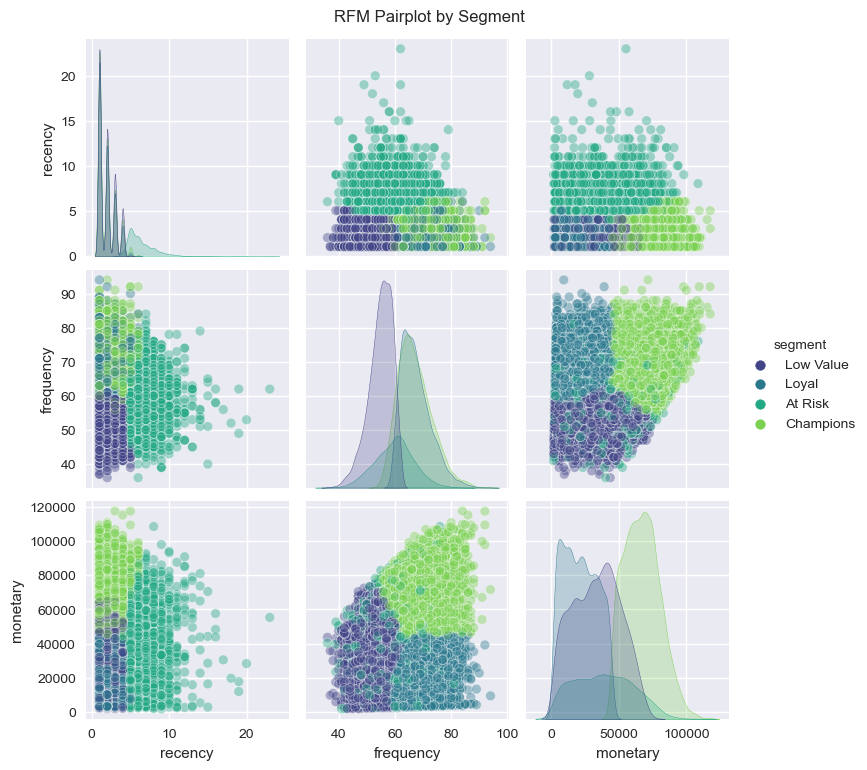

In [67]:
# Pairplot colored by segment
sns.pairplot(rfm.sample(min(len(rfm), 20000)), vars=features, hue="segment", palette="viridis", plot_kws={"alpha":0.4})
plt.suptitle("RFM Pairplot by Segment", y=1.02); plt.show()

### Segment interpretation

- **Champions** – lowest recency (most recent), highest frequency and monetary; priority for loyalty programs and exclusive offers.  
- **Loyal** – frequent buyers with moderate spending; nurture to increase AOV and cross-sell.  
- **At Risk** – high recency (long time since last purchase); target with win-back campaigns and personalized incentives.  
- **Low Value** – low frequency and low monetary; low-cost, broad marketing or onboarding journeys.

Use these segments to tailor promotions, retention strategies, and lifecycle campaigns.


In [71]:
# Save labeled customers for activation in CRM/SQL
rfm_out = rfm[["customerid", "recency", "frequency", "monetary", "segment"]].copy()
rfm_out.to_csv("customer_segments.csv", index=False)
rfm_out.head()

,customerid,recency,frequency,monetary,segment
0,1,2,61,"3,218.39",Loyal
1,2,7,59,"3,228.26",At Risk
2,3,2,61,"2,982.74",Loyal
3,4,1,63,"2,943.81",Loyal
4,5,1,52,"2,546.58",Low Value
